In [1]:
### running GMM without all the DJ code wrapped around it
## we read in output from collate_m and run GMM for various inputs
#  and plot distributions of some parameters
# written early/mid sept 2018, d duncan
# revisited october, 
# cleaned up and finalized plotting routines dec 2018


from sklearn import mixture
from matplotlib.colors import LogNorm, Normalize

nc = 6
run_bic = True

plt.style.use('bmh')

gmm = mixture.GaussianMixture(n_components = nc, covariance_type = 'diag')


In [2]:
typ = 'MSs3'
dir_raw_data = "/home/dudavid/projects/dsd/dj/data/"
# take every _th point to save time when debugging:
per = 1

dm = np.load('../data/alldmd'+typ+'.npy')[::per]
nw = np.log10( np.load('../data/allnwd'+typ+'.npy')[::per] ) # given as log10()
rr = np.load('../data/allrrd'+typ+'.npy')[::per]
la = np.load('../data/alllatd'+typ+'.npy')[::per]
lo = np.load('../data/alllond'+typ+'.npy')[::per]
epo= np.load('../data/allepochd'+typ+'.npy')[::per]
ss = np.load('../data/allssd'+typ+'.npy')[::per]
ku = np.load('../data/allkud'+typ+'.npy')[::per]
ka = np.load('../data/allkad'+typ+'.npy')[::per]
mu = np.load('../data/allmud'+typ+'.npy')[::per]
print(np.mean(mu),np.mean(dm),np.mean(nw))
vcts = np.load(dir_raw_data+'vallcts'+typ+'.80.npy').transpose()[::per,:] # vol-weighted, smoothed
ncts = np.load(dir_raw_data+'normallcts'+typ+'.80.npy').transpose()[::per,:] # vol-weighted and normalized
rcts = np.load(dir_raw_data+'rallcts'+typ+'.80.npy').transpose()[::per,:] # raw (per mm) counts
scts = np.load(dir_raw_data+'snallcts'+typ+'.80.npy').transpose()[::per,:] # smoothed, normalized, not weighted
rwcts =np.load(dir_raw_data+'rwallcts'+typ+'.80.npy').transpose()[::per,:] # RWC-normalized raw
cts = rwcts #ncts #vcts # choose which one to use
print(np.shape(cts))
print(np.shape(rcts))
#cts_zero = cts
#cts_zero[cts==0] = .0001

# read in 80 size bins above, trim to __ in rest of code (most very large bins have snow, not rain)
mb = 60
bye = 1 # how many consecutive bins to sum/avg over
cts_new = np.array([ np.mean(cts[:,x*bye:(x*bye+bye)],axis=1) for x in range(int(mb/bye)) ]).transpose()
rcts_new= np.array([ np.mean(rcts[:,x*bye:(x*bye+bye)],axis=1) for x in range(int(mb/bye)) ]).transpose()
#cts_new = np.log10(np.array([ np.mean(cts_zero[:,x*bye:(x*bye+bye)],axis=1) for x in range(int(mb/bye)) ]).transpose())
#  taking the log of counts smoothed with boxcar filter of length bye
print(np.shape(cts_new))


4.494302672717009 1.17887318164054 3.697365970721966
(92116, 80)
(92116, 80)
(92116, 60)


In [3]:
bn = np.load('/home/dudavid/projects/dsd/oceanrain_binsizes.npy')[12:] # load OR bin limits
mpy = bn[0:mb:bye] # calculate midpoint below
mpy_mid = np.array([ np.mean(mpy[n:n+2]) for n in range(int(mb/bye)) ])
dD = np.array([mpy[n+1]-mpy[n] for n in range(len(mpy)-1)])

# calculate RWC from the raw data  i.e. RWC = rho*sum(4/3 pi r^3 dr)
LWC = np.array([1000.0*np.pi/6 * np.trapz( rcts_new[i,:] * (1e-3*mpy)**3, mpy ) for i in range(len(la))]) 
# should be in kg/m^3 (so multiply by a nominal depth to get an idea of rwp)
print(info(LWC)) 
print(np.shape(LWC))

(60,)
['5.62E-6', '1.24E-2', '1.99E-4', '3.53E-4']
(92116,)


In [4]:
# averaging over consecutive time steps to give a little spatial averaging sense
#   [if location varies very little for consecutive points then put them together]
#cts_new = np.array([ np.mean(cts[:,x*bye:(x*bye+bye)],axis=1) for x in range(int(mb/bye)) ]).transpose()
en = np.size(LWC)
cts_newer = cts_new
rcts_newer = rcts_new
mo = 0 # set to 3 in paper for RT simulations, but not here (set as 0 for unsmoothed)
for f in range(en-2*mo)[mo:]:
    space_var = np.std(lo[(f-mo):(f+mo+1)])+np.std(la[(f-mo):(f+mo+1)])
    time_var  = np.std(epo[(f-mo):(f+mo+1)])
    if space_var < 0.1 and time_var < 500:  # so ~10km max, mostly within 500s?
        cts_newer[f,:] = np.mean(cts_new[(f-mo):(f+mo+1),:], axis=0)
        rcts_newer[f,:] = np.mean(rcts_new[(f-mo):(f+mo+1),:], axis=0)

In [5]:
# try to reproduce the raw data as in leinonen 2012 (fig13; by Do), bringi 2003 (fig4; by Dm)
# need to normalize x-axis by Dm and y-axis by Nw -- practically can divide counts by given Nw 
#  for each data point

justsome = np.array([abs(la) <= 90]).ravel() # all at first
thng = rcts_new[justsome,:]
savex, savey = [], []
for x in range(np.shape(thng)[0]):
    dnor = mpy / dm[justsome][x] 
    nnor = thng[x,:] / (10**nw[justsome][x])
    savex.extend(dnor)
    savey.extend(nnor)
print(np.shape(savex),len(savey))
savex, savey = np.array(savex), np.array(savey)
savx = savex[savey>0]
savy = savey[savey>0] # to remove zeros for log10 calc


justsome = np.array([abs(la) > 50]).ravel() # high lat (h)
thng = rcts_new[justsome,:]
print(np.shape(thng))
savexh, saveyh = [], []
for x in range(np.shape(thng)[0]):
    dnor = mpy / dm[justsome][x] 
    nnor = thng[x,:] / (10**nw[justsome][x])
    savexh.extend(dnor)
    saveyh.extend(nnor)
print(np.shape(savexh),len(saveyh))
savexh, saveyh = np.array(savexh), np.array(saveyh)
savxh = savexh[saveyh>0]
savyh = saveyh[saveyh>0] # to remove zeros for log10 calc

justsome = np.array([abs(la) <= 20]).ravel() # tropics (t)
thng = rcts_new[justsome,:]
print(np.shape(thng))
savext, saveyt = [], []
for x in range(np.shape(thng)[0]):
    dnor = mpy / dm[justsome][x] 
    nnor = thng[x,:] / (10**nw[justsome][x])
    savext.extend(dnor)
    saveyt.extend(nnor)
print(np.shape(savext),len(saveyt))
savext, saveyt = np.array(savext), np.array(saveyt)
savxt = savext[saveyt>0]
savyt = saveyt[saveyt>0] # to remove zeros for log10 calc

(92116, 60)
(5526960,) 5526960
(36088, 60)
(2165280,) 2165280
(20521, 60)
(1231260,) 1231260


['-8.61E+0', '3.76E+0', '-1.72E+0', '8.74E-1'] (2342354,)
mu array:  [-3. -2. -1.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14.
 15.]
(150, 90) (91,)
(150,)


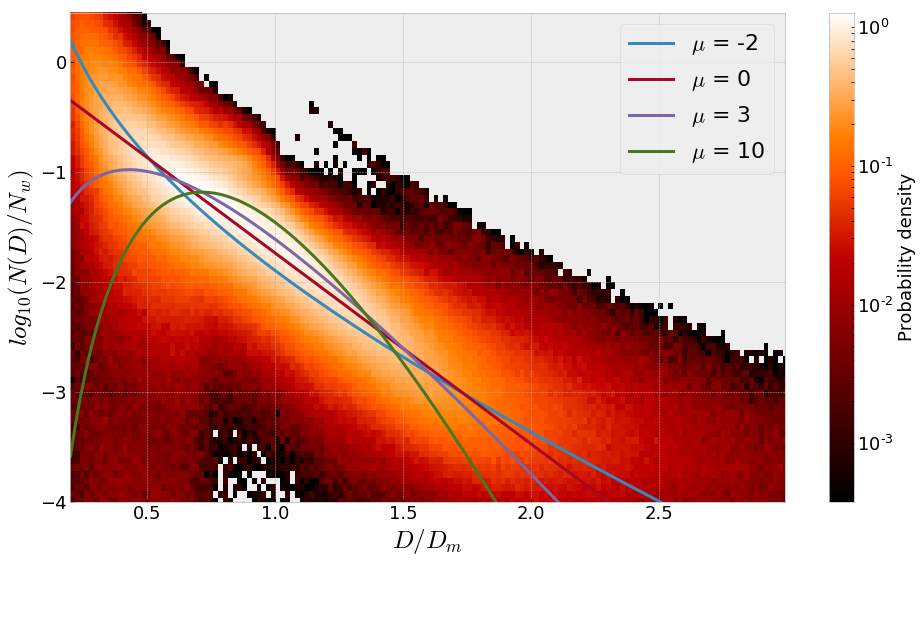

In [17]:

#print(info(np.log10(savy)),np.shape(savy))

# to insert lines for given mu values, N(D) = Nw*f(mu)*(D/Dm)**mu *exp(-(4+mu)*D/Dm), so 
#  N(D)/Nw = f(mu)*X**mu *exp(-(4+mu)*X)  where X=D/Dm
xmin, xmax = .2, 3.0
plex = np.arange(xmin,xmax,.02)
plmu = np.float128(np.arange(-3, 16)) # as in Bringi paper [need float128 or else mu>12 bombs in exponent]
gams = [math.gamma(x+4) for x in plmu]
print('mu array: ',plmu)
eff = (6/(4**4)) * (4+plmu)**(plmu+4) / gams 

fs = 22
plt.style.use('bmh') #ggplot')
f1 = plt.figure(figsize=[16,9])
cs, xx, yy, img = plt.hist2d(savx, np.log10(savy), bins=[150,90], range=[[xmin,xmax], [-5,.5]], cmap=plt.get_cmap('gist_heat'),\
           normed=1,norm=LogNorm())#,cmin=20) #,title='Histogram of...
print(np.shape(cs),np.shape(yy))
ymid = (yy[1:] + yy[:-1]) / 2
xmid = (xx[1:] + xx[:-1]) / 2
maxd = [ ymid[cs[x,:]==np.max(cs[x,:])][0] for x in range(len(xx)-1)]
print(np.shape(maxd))


cb = plt.colorbar()
cb.set_label('Probability density',fontsize=fs-4)
plt.ylim([-4,.45])
cb.ax.tick_params(labelsize=fs-4)
plt.xlim([xmin, xmax-.01])
plt.xlabel(r'$D/D_m$',fontsize=fs+3)
plt.ylabel(r'$log_{10} (N(D)/N_w)$',fontsize=fs+3)
plt.xticks(fontsize=fs-4)
plt.yticks([-4,-3,-2,-1,0],fontsize=fs-4)

for emu in [1,3,6,13]:  # subsets are defined relative to ranged given above!
    plt.plot(plex, np.log10(eff[emu]*(plex**plmu[emu])*np.exp(-(4+plmu[emu])*plex)),\
             linewidth=3,label="""$\mu$"""+' = '+str(emu-3))
plt.legend(fontsize=fs)
pvr = 'v5'
f1.savefig('../../img/data_gammas_exp-pdf_'+pvr+'.png',dpi=350,bbox_inches='tight')
#   for some reason, extra space at bottom of figure?
# MAYBE USING LIMITS DIFFERENT FROM THOSE OF THE 2DHIST ARE MESSING UP THE BBOX_INCHES CALL?
plt.show()

In [7]:

#his2d_lp5 = np.histogram2d(savx, np.log10(savy), bins=[150,90], range=[[xmin,xmax], [-5,.5]], normed=1)#[0] # just histo
#print(np.shape(his2d_lp5[0]))

In [8]:

#his2d_g2 = np.histogram2d(savx, np.log10(savy), bins=(x, y), range=[[xmin,xmax], [-5,.5]], normed=1)#[0] # just histo
#print(np.shape(his2d_g2[0]))

In [9]:

his2d_hl = np.histogram2d(savxh, np.log10(savyh), bins=(xx, yy), range=[[xmin,xmax], [-5,.5]], normed=1)
maxd_hl = [ ymid[his2d_hl[0][x,:]==np.max(his2d_hl[0][x,:])][0] for x in range(len(xx)-1)] 

his2d_trop = np.histogram2d(savxt, np.log10(savyt), bins=(xx, yy), range=[[xmin,xmax], [-5,.5]], normed=1)
maxd_tr = [ ymid[his2d_trop[0][x,:]==np.max(his2d_trop[0][x,:])][0] for x in range(len(xx)-1)]

(150, 90)


(151,) (150, 90)


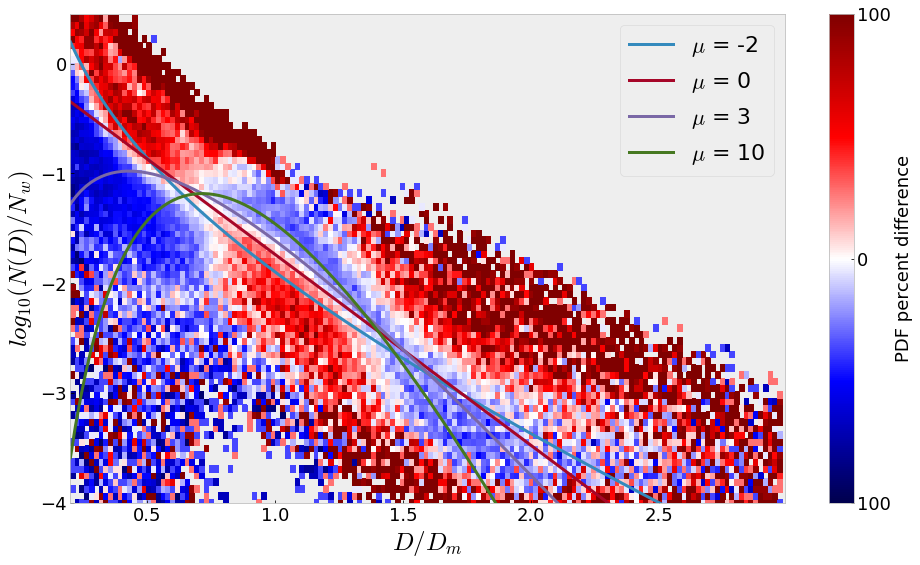

NameError: name 'andstop' is not defined

In [16]:
## plot difference of the chosen 2d histograms:

print(np.shape(xx),np.shape(his2d_trop[0]))
gu = np.logical_and(his2d_trop[0] > 0.000, his2d_hl[0] > 0.000) # choose points where both hists defined
toplot = np.zeros_like(his2d_trop[0])+np.nan
toplot[gu] = 100*(his2d_hl[0][gu]-his2d_trop[0][gu])/his2d_trop[0][gu] #/his2d_lp5[gu]

hd = plt.figure(figsize=[16,9])
vm = 100
plt.pcolor(xx[:-1], yy[:-1], toplot.transpose(), cmap=plt.get_cmap('seismic') , vmin=-vm, vmax=vm)
cb2 = plt.colorbar(ticks=[-vm,0,vm])
cb2.set_label('PDF percent difference',fontsize=fs-4)
#cb2.set_label('Probability density difference',fontsize=fs-4)
cb2.ax.tick_params(labelsize=fs-4)
cb2.ax.set_yticklabels([str(round(vm,1)),'0',str(round(vm,1))])
plt.ylim([-4,.45])
plt.xlim([xmin,xmax-.01])
plt.xlabel(r'$D/D_m$',fontsize=fs+3)
plt.ylabel(r'$log_{10} (N(D)/N_w)$',fontsize=fs+3)
plt.xticks(fontsize=fs-4)
#plt.xticks([0.5,1.0,1.5,2.0,2.5,3.0],fontsize=fs-4)
plt.yticks([-4,-3,-2,-1,0],fontsize=fs-4)
for emu in [1,3,6,13]:  # subsets are defined relative to ranged given above!
    plt.plot(plex, np.log10(eff[emu]*(plex**plmu[emu])*np.exp(-(4+plmu[emu])*plex)),\
             linewidth=3,label="""$\mu$"""+' = '+str(emu-3))
#plt.plot(xmid, maxd_hl, linewidth=4,label='PDF_hl max')
#plt.plot(xmid, maxd_tr, linewidth=4,label='PDF_trop max')
plt.legend(fontsize=fs)
pvr='v5c'
hd.savefig('../../img/data_gamma-diff_exp-pdf_'+pvr+'.png',dpi=350,bbox_inches='tight')
#hd.savefig('../../img/data_gamma-diff_exp-pdf_'+pvr+'.png',dpi=350,transparent=True,bbox_inches='tight')
plt.show()

In [ ]:
# look at the 'gaussian-ness' or ability to maybe be represented by gaussians... of individual PDFs:
#plt.hist(nw,bins=50,label='nw') 
#plt.show()
#plt.hist(cts_new[:,0], bins=50, label='Counts in one bin', alpha=0.5) 
#plt.hist(cts_new[:,7], bins=50, label='Counts in another bin', alpha=0.5) 
#plt.hist(cts_new[:,37], bins=50, label='Counts in another bin', alpha=0.5) 
#plt.hist(np.log10(cts_new[:,1]), bins=50) 
#plt.show()
#plt.hist(rr,bins=50, label='log RR') 
#plt.show()
#dem = np.log10(dm)
#plt.hist(dm,bins=50, label='log Dm') 
#plt.show()
#plt.hist(mu,bins=50) 
#plt.show()

In [18]:
#obj = np.transpose([dm, nw, rr, mu])
#print(np.shape(cts),np.shape(nw.reshape(len(nw),1)))
# OBJ defines the array used for GMM classification in rest of code
first = len(nw) # if wanting to limit GMM calc 
obj = cts_newer[:first,:]
#obj = np.hstack([cts_new[:first,:], enw[:first,:] , err[:first,:]]) # could use other vars too...
print(np.shape(obj))

nc1 = 6
gmm = mixture.GaussianMixture(n_components = nc, covariance_type = 'diag') # setup GMM py object
gmm.fit(obj)

post_prob6 = gmm.predict_proba(obj)
labels6 = gmm.predict(obj)
labels = labels6 # just to not break below code
bic_score = gmm.bic(obj)
means6 = np.squeeze(gmm.means_)

#print('BIC score: ', bic_score)
np.save('Data_store/GMM-labels_rwcnorm_'+str(nc)+'.'+typ, labels6)
np.save('Data_store/GMM-postprob_rwcnorm_'+str(nc)+'.'+typ, post_prob6)

ncx = 14 # this is 'x'
gmm = mixture.GaussianMixture(n_components = ncx, covariance_type = 'diag') # setup GMM py object
gmm.fit(obj)

post_probx = gmm.predict_proba(obj)
labelsx = gmm.predict(obj)
bic_score = gmm.bic(obj)
meansx= np.squeeze(gmm.means_)
print(np.shape(meansx))
#print('BIC score: ', bic_score)

(92116, 60)
BIC score:  -40799300.78487476
(14, 60)
BIC score:  -42655569.31037379


In [19]:
# calculate mean N(D) curves from 'M' data after using the normalized data in GMM.
# 'raw_means' is kind of misleading, as these are mean GMM curves with equal RWC!

raw_means6 = np.empty_like(means6) # init
# normalize so that all have equal RWC!
for en in range(nc1):
    klass = [labels6==en][0]
    rem = np.squeeze(rcts_newer[klass,:])
    raw_means6[en,:] = np.mean(rem,axis=0)
rwc_avg6 = 1000.0*np.pi/6 * np.mean([np.trapz(raw_means6[en,:] * (1e-3*mpy)**3, mpy) for en in range(nc1)])
for en in range(nc1):
    rwc_here = 1000.0*np.pi/6 * np.trapz(raw_means6[en,:] * (1e-3*mpy)**3, mpy)
    raw_means6[en,:] *= rwc_avg6/rwc_here
    
raw_meansx = np.empty_like(meansx) # init
for en in range(ncx):
    klass = [labelsx==en][0]
    rem = np.squeeze(rcts_newer[klass,:])
    raw_meansx[en,:] = np.mean(rem,axis=0)
rwc_avgx = 1000.0*np.pi/6 * np.mean([np.trapz(raw_meansx[en,:] * (1e-3*mpy)**3, mpy) for en in range(ncx)])
for en in range(ncx):
    rwc_here = 1000.0*np.pi/x * np.trapz(raw_meansx[en,:] * (1e-3*mpy)**3, mpy)
    raw_meansx[en,:] *= rwc_avgx/rwc_here
    

# output the N(D) arrays (used in simulation.ipynb):
np.save('Data_store/ND_rwcnorm_'+str(nc1), raw_means6)
np.save('Data_store/ND_rwcnorm_'+str(ncx), raw_meansx)

In [ ]:
hdd=plt.figure(figsize=[12,9])
for x in range(nc6):
    plt.plot(mpy[:-1], raw_means6[x,:-1],linestyle='--',label=str(x+1))
    
fs= 15
plt.legend(fontsize=fs)
plt.xlabel("Drop diameter [mm]",fontsize=fs)
plt.ylabel(r"N(D) [$mm^{-1} m^{-3}$]",fontsize=fs)
plt.yscale('log')
plt.title('Mean shapes, raw counts',fontsize=fs)
plt.ylim([5e0, 7e3])
plt.xlim([0.4, 3])

plt.show()
pvr = 'v1'
hdd.savefig('../../img/gmm_mean-shapes_noS.'+pvr+'.png',dpi=350)

In [ ]:
plt.figure(figsize=[12,9])

hay = 1
for en in range(nc):
    klass = [labels==en][0] #[::hay]
    #print(len(dm[klass]))
    print(info(dm[klass]))
    plt.scatter((dm[klass])[::hay],nw[klass][::hay], s=1.8, marker='.', label='Class '+str(en+1))
    
plt.xlabel('Dm [mm]')
plt.ylabel('log(Nw) [mm-1 m-3]')
plt.xscale('log')
plt.xlim([.5,4])
plt.ylim([1.5,6])
plt.legend(markerscale=12,fontsize=14)
plt.show()

In [ ]:
plt.figure(figsize=[12,9])

for en in range(nc):
    klass = [labels==en][0]
    plt.scatter(nw[klass],ku[klass],s=1.8,  marker='.', label='Class '+str(en+1))
    #plt.scatter(dm[klass],rr[klass],s=1.8,  marker='.', label='Class '+str(en+1))
    
#plt.yscale('log')
plt.xlim([1.5,6])
plt.ylim([5,55])
#plt.xlim([.3,3])
#plt.ylim([.2,30])
plt.xlabel('Nw [log10()]')#Dm [mm]')
plt.ylabel('Ku [dBZ]') #RR [mm/h]')
plt.legend(markerscale=12,fontsize=14)
plt.show()

In [ ]:
tit =  'Latitude'
incr = 15
bins = np.arange(-60,85,incr)
dhist = np.zeros([len(bins)-1,nc])
fig = plt.figure(figsize=[11,9])
var = la
for n in range(nc):
    if n==0: adhist = np.histogram(var,bins=bins)[0]
    class_n = [labels == n] #[most_prob==n][0]
    print(np.size(var[class_n]))
    dhist[:,n] = np.histogram(var[class_n],bins=bins)[0] / adhist
    plt.plot(bins[:-1]+incr/2,dhist[:,n], label='class '+str(n+1))#'  ('+sp[n]+'%)')
    
plt.title(tit+" histograms by class",fontsize=14)
plt.xlabel(tit,fontsize=14)
plt.ylabel("Frequency",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.ylim([0.0,0.6])
plt.legend(fontsize=14)
plt.show()

In [ ]:
tit =  'SST'
incr = 5
bins = np.arange(0,30,incr)
dhist = np.zeros([len(bins)-1,nc])
fig = plt.figure(figsize=[11,9])
var = ss
for n in range(nc):
    if n==0: adhist = np.histogram(var,bins=bins)[0]
    class_n = [labels == n] #[most_prob==n][0]
    print(np.size(var[class_n]))
    dhist[:,n] = np.histogram(var[class_n],bins=bins)[0] / adhist
    plt.plot(bins[:-1]+incr/2,dhist[:,n], label='class '+str(n+1))#'  ('+sp[n]+'%)')
    
plt.title(tit+" histograms by class",fontsize=14)
plt.xlabel(tit,fontsize=14)
plt.ylabel("Frequency",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.ylim([0.0,0.6])
plt.legend(fontsize=14)
plt.show()

In [ ]:
tit =  'Dm'
bins = [.4,.45,.5,.55,.6,.65,.7,.75,.8,.85,.9,.95,1,1.1,1.2,1.3,1.4,1.5,1.6,1.8,2.0,2.2,2.4,2.6,2.8,3,3.5,4]#,256]
dhist = np.zeros([len(bins)-1,nc])
fig = plt.figure(figsize=[11,9])
var = dm  # since took log10 above
for n in range(nc):
    if n==0: adhist = np.histogram(var,bins=bins)[0]
    class_n = [labels == n] #[most_prob==n][0]
    print(np.size(var[class_n]))
    dhist[:,n] = np.histogram(var[class_n],bins=bins)[0] / adhist
    plt.plot(bins[:-1],dhist[:,n],label='class '+str(n+1))#'  ('+sp[n]+'%)')
    
plt.title(tit+" histograms by class",fontsize=14)
plt.xlabel(tit+" [mm]",fontsize=14)
plt.ylabel("Frequency",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.ylim([0.0,0.6])
plt.legend(fontsize=14)
plt.show()

In [ ]:
tit =  'Ku reflectivity'
bins = np.linspace(5,55,26)
dhist = np.zeros([len(bins)-1,nc])
fig = plt.figure(figsize=[11,9])
var = ku  # since took log10 above
for n in range(nc):
    if n==0: adhist = np.histogram(var,bins=bins)[0]
    class_n = [labels == n] #[most_prob==n][0]
    print(np.size(var[class_n]))
    dhist[:,n] = np.histogram(var[class_n],bins=bins)[0] / adhist
    plt.plot(bins[:-1],dhist[:,n],label='class '+str(n+1))#'  ('+sp[n]+'%)')
    
plt.title(tit+" histograms by class",fontsize=14)
plt.xlabel(tit+" [mm]",fontsize=14)
plt.ylabel("Frequency",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.ylim([0.0,0.6])
plt.legend(fontsize=14)
plt.show()

In [ ]:
tit= 'Nw'
bins = [1,1.5,2.0,2.5,2.75,3.0,3.25,3.5,3.75,4,4.25,4.5,4.75,5,5.25,5.5,5.75,6,6.5]
dhist = np.zeros([len(bins)-1,nc])
fig = plt.figure(figsize=[11,9])
var = nw  # since took log10 above
for n in range(nc):
    if n==0: adhist = np.histogram(var,bins=bins)[0]
    class_n = [labels == n] #[most_prob==n][0]
    print(np.size(var[class_n]))
    dhist[:,n] = np.histogram(var[class_n],bins=bins)[0] / adhist
    plt.plot(bins[:-1],dhist[:,n],label='class '+str(n+1))#'  ('+sp[n]+'%)')
    
plt.title(tit+" histograms by class",fontsize=14)
plt.xlabel("log10("+tit+") [mm^-1 m^-3]",fontsize=14)
plt.ylabel("Frequency",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.ylim([0.0,0.6])
plt.legend(fontsize=14)
plt.show()

In [ ]:
tit = 'RR'
bins = [.1,.2,.3,.4,.5,.6,.7,.8,.9,1,1.1,1.25,1.5,1.8,2.5,4,6,10,16,24,36,64]#,256]
dhist = np.zeros([len(bins)-1,nc])
fig = plt.figure(figsize=[11,9])
var = rr
print(info(rr))
for n in range(nc):
    if n==0: 
        adhist = np.histogram(var,bins=bins)[0]
        print(adhist)
    class_n = [labels == n] #[most_prob==n][0]
    print(np.size(var[class_n]))
    dhist[:,n] = np.histogram(var[class_n],bins=bins)[0] / adhist
    plt.plot(bins[:-1],dhist[:,n],label='class '+str(n+1))#'  ('+sp[n]+'%)')
    
plt.title(tit+" histograms by class",fontsize=14)
plt.xlabel(tit+" [mm/hr]",fontsize=14)
plt.ylabel("Frequency",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.ylim([0.0,0.6])
plt.xscale('log')
plt.legend(fontsize=14)
plt.show()

In [ ]:
tit = 'RWC'
bins = np.array([.1,.2,.3,.4,.5,.6,.7,.8,.9,1.05,1.25,1.5,2,3,5,8,16,32,64])*1e-4 #,256]
print(bins)
dhist = np.zeros([len(bins)-1,nc])
fig = plt.figure(figsize=[11,9])
var = LWC
print(np.shape(var))
print(info(var))
for n in range(nc):
    if n==0: 
        adhist = np.histogram(var,bins=bins)[0]
        print(adhist)
    class_n = [labels == n] #[most_prob==n][0]
    print(np.size(var[class_n]))
    dhist[:,n] = np.histogram(var[class_n],bins=bins)[0] / adhist
    plt.plot(bins[:-1],dhist[:,n],label='class '+str(n+1))#'  ('+sp[n]+'%)')
    
plt.title(tit+" histograms by class",fontsize=14)
plt.xlabel(tit+" [kg/m3]",fontsize=14)
plt.ylabel("Frequency",fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim([bins[0],bins[-1]])
#plt.ylim([0.0,0.6])
plt.xscale('log')
plt.legend(fontsize=14)
plt.show()

In [20]:
def mgd(in_D,in_Dm,in_mu,in_RWC): #Nw):
    """
     Calcuate the Modified Gamma drop size distribution

     Input (note, all inputs should be vectors of same size!) : 
            in_D:  vector of diameters [mm]
            in_Dm: mass-weighted mean diameter [mm]
            in_mu: shape parameter [dim-less]
            in_RWC: RWC [kg m-3]
            #in_Nw: normalized intercept parameter [IN LOG10()!!] [mm-1 m-3]
     output: N(D) [len(in_D)] in m^{-3} mm^{-1}
    """
    if(len(in_D)==1):
        print("need to input vector for in_D")
    enot = (4**4)/(np.pi*1000.0) * in_RWC/((in_Dm*1e-3)**4) *1e-3 
    # calc intercept param from RWC, Dm -- get units into mm-1 m-3
    #enot = 10**in_Nw
    eff = 6/(4**4) * ((4+in_mu)**(4+in_mu) ) / math.gamma(np.float128(4+in_mu))
    ModGam = enot * eff * (in_D/in_Dm)**in_mu * np.exp(-(4+in_mu)*in_D/in_Dm)
    return ModGam

In [21]:
# calculate MP and some token MGD curves to plot alongside GMM states:
# use same rwc as the raw_means plotted at the same time
raw_rwc = 1000.0*np.pi/6 * np.trapz(raw_means6[0,:] * (1e-3*mpy)**3, mpy) # should all be the same
print(raw_rwc)
#vel = 3.78*(mpy_mid**0.67) # D in mm, vel in m/s  [e.g. Bringi et al. 2004]
#raw_rain = [1e-6 * 3600*np.pi/6.0* np.trapz( mpy[:]**3 * (raw_means6[i,:])*vel, x=mpy) \
#            for i in range(nc)]
#print(raw_rain)
#rain = rain + (epi/6.0)*D*D*D*num*vel*dD*1e-6

#mpy = plex
#marshp_h = 8000.0*np.exp(-4.1*np.max(raw_rain)**(-0.21) *mpy) # MP for highest RR from raw_means
#marshp_l = 8000.0*np.exp(-4.1*np.min(raw_rain)**(-0.21) *mpy) # MP for lowest ""
dm1, mu1 = 1.3, 5  # some sample Dm and mu values for plotting
dm2, mu2 = 1.8, 2
dm0 = 1.5
mgd1 = mgd(mpy, dm1, mu1, raw_rwc)
mgd2 = mgd(mpy, dm2, mu2, raw_rwc)
mgd0 = mgd(mpy, dm0, 0, raw_rwc)


0.00022468478985580617
[3.2960940303489092, 2.5438339783232644, 4.750799637593783, 3.902897724215262, 4.034856691040168, 3.1974925779354657]


In [22]:
# can run the BIC calculator for bee regimes
bee = np.array([2,4,6,14])
fie, ax = plt.subplots(nrows=2, ncols=2, figsize=[14,14],sharex=True,sharey=True)
if run_bic:
    for b in range(len(bee)):
        gmm = None
        gmm = mixture.GaussianMixture(n_components = bee[b], covariance_type = 'diag')
        gmm.fit(obj)
        bic_score = gmm.bic(obj)
        print('BIC score, ncomp = ',str(bee[b]),': ', '{:.2e}'.format(bic_score)) #, aic_score)
        
        raw_mns = np.squeeze(gmm.means_) # init
        labels2 = gmm.predict(obj)
        nac = bee[b] #+1
        print(b,nac)
        nks = []
        for en in range(nac):
            klass = [labels2==en][0]
            nks.append(len(np.where(klass==True)[0]))
            raw_mns[en,:] = np.mean(np.squeeze(rcts_new[klass,:]),axis=0)
        nks = np.round(np.array(nks)/np.shape(obj)[0] *100, 1) # should be pct 
            
        # same procedure as above, normalize so that each curve has equal RWC:
        rwc_avg = 1000.0*np.pi/6 * np.mean([np.trapz(raw_mns[en,:] * (1e-3*mpy)**3, mpy) for en in range(nac)])
        for en in range(nac):
            rwc_here = 1000.0*np.pi/6 * np.trapz(raw_mns[en,:] * (1e-3*mpy)**3, mpy)
            raw_mns[en,:] *= rwc_avg/rwc_here
            
        
        ey = np.mod(b,2) # indices for axis array
        ex = int(b/2)
        ax[ex,ey].plot(mpy, mgd1, 'g', label='$D_m$='+str(dm1)+', $\mu$='+str(int(mu1)))
        ax[ex,ey].plot(mpy, mgd2, 'b', label='$D_m$='+str(dm2)+', $\mu$='+str(int(mu2)))
        ax[ex,ey].plot(mpy, mgd0, 'k', label='$D_m$='+str(dm0)+', $\mu$=0')
        
        for x in range(nac):
            if bee[b]<10:     # only plotting fewer lines if over 10
                ax[ex,ey].plot(mpy[:-1], raw_mns[x,:-1],linestyle='--',label=str(x+1)+'   ('+str(nks[x])+'%)')
            elif bee[b]>10 and np.mod(x,2)==1:
                ax[ex,ey].plot(mpy[:-1], raw_mns[x,:-1],linestyle='--',label=str(x+1)+'   ('+str(nks[x])+'%)')
                
            
        fs= 15
        ax[ex,ey].set_yscale('log')
        ax[ex,ey].set_title('$N_{GMM}$ = '+str(nac),fontsize=fs+4)
        ax[ex,ey].set_ylim([2e0, 8e3])
        ax[ex,ey].set_xlim([0.5, 3])
        ax[ex,ey].legend(fontsize=fs-2, loc='upper right')
        
ax[1,0].set_xlabel("D [$mm$]",fontsize=fs+2)
ax[1,1].set_xlabel("D [$mm$]",fontsize=fs+2)
ax[1,0].tick_params(labelsize=fs-1,axis='both')
ax[1,1].tick_params(labelsize=fs-1,axis='both')
ax[0,0].tick_params(labelsize=fs-1,axis='both')
ax[0,0].set_ylabel(r"N(D) [$mm^{-1} m^{-3}$]",fontsize=fs+2)
ax[1,0].set_ylabel(r"N(D) [$mm^{-1} m^{-3}$]",fontsize=fs+2)
pvr = 'v2'
fie.savefig('../../img/gmm-multi_'+str(len(bee))+'_'+pvr+'.png',dpi=300,bbox_inches="tight",transparent=True)

BIC score, ncomp =  2 :  -3.72e+07
0 2
BIC score, ncomp =  4 :  -3.96e+07
1 4
BIC score, ncomp =  6 :  -4.08e+07
2 6
BIC score, ncomp =  14 :  -4.27e+07
3 14


case #s:  [62179 21692 45581 71280]
Lat:  69.6794 Lon:  18.996 SST:  8.6
GMM #:  1 PP:  [1. 0. 0. 0. 0. 0.]
GMMx #:  2 PP:  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Lat:  -11.4997 Lon:  -33.2168 SST:  27.7
GMM #:  1 PP:  [1. 0. 0. 0. 0. 0.]
GMMx #:  10 PP:  [0.376 0.    0.    0.    0.    0.    0.    0.    0.    0.624 0.    0.
 0.    0.   ]
Lat:  -53.1762 Lon:  -70.8927 SST:  9.5
GMM #:  5 PP:  [0. 0. 0. 0. 1. 0.]
GMMx #:  9 PP:  [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Lat:  -17.0082 Lon:  175.7317 SST:  -99.9
GMM #:  1 PP:  [0.932 0.    0.    0.    0.068 0.   ]
GMMx #:  9 PP:  [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


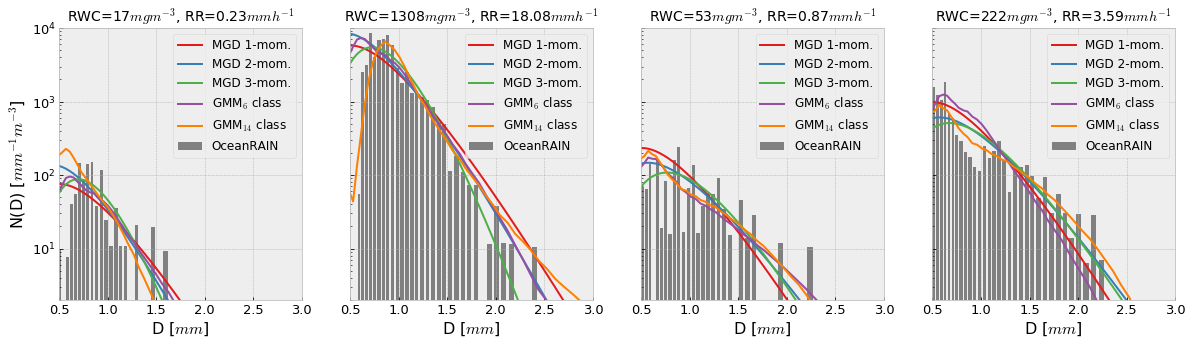

In [29]:
# create sample plot of random DSD index as input,
#  and it plots the native, corresponding MGD curve from OR, and various most-likely
#  GMM states... 
#case = [2222, 921]
ncas = 4
case = np.random.choice(range(len(dm)),ncas)
case[1] = 21692 # this is a useful example to show with curve down at low D values
#case = [27637,87307,10122,15099]
cols = ['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00'] # via colorbrewer (qualitative, n=5)
print('case #s: ',case)
fie2, ax2 = plt.subplots(nrows=1, ncols=ncas, figsize=[5*ncas,5],sharex=True,sharey=True)
fs = 14

for c in range(len(case)):
    # bar plot first, skinny so they don't overlap
    ax2[c].bar(mpy_mid[:-1], rcts_new[case[c],:-1], label='OceanRAIN', log=True, align='center',width=dD*.7, \
              color='gray',ecolor='black')
    
    emgeedee =  mgd(mpy[:-1], dm[case[c]], mu[case[c]], LWC[case[c]]) # 3-moment (given by OR)
    emgeedee2 = mgd(mpy[:-1], dm[case[c]], 3, LWC[case[c]])           # 2-moment (assume mu)
    emgeedee1 = mgd(mpy[:-1], np.mean(dm), 3, LWC[case[c]])           # 1-moment (prescribe dm too)
    
    ax2[c].plot(mpy[:-1], emgeedee1, label='MGD 1-mom.', color=cols[0])
    ax2[c].plot(mpy[:-1], emgeedee2, label='MGD 2-mom.', color=cols[1])
    ax2[c].plot(mpy[:-1], emgeedee,  label='MGD 3-mom.', color=cols[2])
    
    means_right_rwc6 = raw_means6 # init
    rwc_avg = 1000.0*np.pi/6 * np.trapz(raw_means6[0,:] * (1e-3*mpy)**3, mpy) # same for all, done above
    means_right_rwc6 = raw_means6[labels6[case[c]],:-1] * LWC[case[c]]/rwc_avg # scale to get right RWC
    ax2[c].plot(mpy[:-1], means_right_rwc6, label=r'GMM$_'+str(nc1)+'$ class', color=cols[3])
    
    means_right_rwcx = raw_meansx # init
    rwc_avg = 1000.0*np.pi/6 * np.trapz(raw_meansx[0,:] * (1e-3*mpy)**3, mpy) # same for all, done above
    means_right_rwcx = raw_meansx[labelsx[case[c]],:-1] * LWC[case[c]]/rwc_avg # scale to get right RWC
    ax2[c].plot(mpy[:-1], means_right_rwcx, label=r'GMM$_{'+str(ncx)+'}$ class', color=cols[4])
    
    tit = r'RWC='+str(int(round(LWC[case[c]]*1e6)))+'$mg m^{-3}$, RR='+str(round(rr[case[c]],2))+'$mm h^{-1}$'
    #ax2[c].set_yscale('log') # overridden by log keyword set in bar above
    ax2[c].set_title(tit,fontsize=fs)
    ax2[c].set_ylim([2e0, 1e4])
    ax2[c].set_xlim([0.5, 3])
    ax2[c].legend(fontsize=fs-2, loc='upper right')
    ax2[c].set_xlabel("D [$mm$]",fontsize=fs+2)
    ax2[c].tick_params(labelsize=fs-1,axis='both')
    print('Lat: ',la[case[c]], 'Lon: ',lo[case[c]], 'SST: ',ss[case[c]])
    print('GMM #: ',labels[case[c]]+1, 'PP: ',np.round(post_prob6[case[c],:],3))
    print('GMMx #: ',labelsx[case[c]]+1, 'PP: ',np.round(post_probx[case[c],:],3))
    
ax2[0].set_ylabel(r"N(D) [$mm^{-1} m^{-3}$]",fontsize=fs+2)
pvr = 'v4'
ctit = '_'.join([str(x) for x in case]) # concatenate case#s into string for filename
fie2.savefig('../../img/cases_'+ctit+'_'+pvr+'.png',dpi=300,bbox_inches="tight",transparent=True)
plt.show()

In [ ]:
dontrunthiscellnow
# can run the BIC calculator for 1 to nb regimes here (takes a while)
print(np.shape(obj))
nb = 7
bee = np.arange(1,nb)*2
if run_bic:
    for b in bee:
        gmm = None
        gmm = mixture.GaussianMixture(n_components = b, covariance_type = 'diag')
        gmm.fit(obj)#.reshape(-1,1))
        bic_score = gmm.bic(obj)#.reshape(-1,1))
        #aic_score = gmm.aic(obj.reshape(-1,1))
        print('BIC score, ncomp = ',str(b+1),': ', '{:.2e}'.format(bic_score)) #, aic_score)
        
        raw_means = np.squeeze(gmm.means_) # init
        labels2 = gmm.predict(obj)
        nac = b #+1
        nks = []
        for en in range(nac):
            klass = [labels2==en][0]
            nks.append(len(np.where(klass==True)[0]))
            #rem = np.squeeze(rcts_new[klass,:])
            raw_means[en,:] = np.mean(np.squeeze(rcts_new[klass,:]),axis=0)
            
        # same procedure as above, normalize so that each curve has equal RWC:
        rwc_avg = 1000.0*np.pi/6 * np.mean([np.trapz(raw_means[en,:] * (1e-3*mpy)**3, mpy) for en in range(nac)])
        for en in range(nac):
            rwc_here = 1000.0*np.pi/6 * np.trapz(raw_means[en,:] * (1e-3*mpy)**3, mpy)
            raw_means[en,:] *= rwc_avg/rwc_here
            
        f = plt.figure(figsize=[12,9])
        
        plt.plot(mpy, marshp_h, 'k', label='MP High')
        plt.plot(mpy, marshp_l, 'k', label='MP low')
        plt.plot(mpy, mgd1, 'b', label='MGD $D_m$='+str(dm1)+', $\mu$='+str(mu1))
        plt.plot(mpy, mgd2, 'b', label='MGD $D_m$='+str(dm2)+', $\mu$='+str(mu2))
        
        for x in range(nac):
            plt.plot(mpy[:-1], raw_means[x,:-1],linestyle='--',label=str(x+1)+'   ('+str(nks[x])+')')
            
        fs= 15
        #plt.yticks(y[::ysb],strbs[::ysb],fontsize=fs)
        plt.xlabel("D [$mm$]",fontsize=fs+2)
        plt.ylabel(r"N(D) [$mm^{-1} m^{-3}$]",fontsize=fs+2)
        plt.yscale('log')
        plt.title('$N_{GMM}$ = '+str(nac),fontsize=fs+4)
        #plt.title('Mean shapes, raw, '+str(nac),fontsize=fs)
        plt.ylim([2e0, 8e3])
        plt.xlim([0.5, 3])
        
        plt.legend(fontsize=fs, loc='upper right')
        f.savefig('../../img/nGMM_'+str(b)+'.v1.png',dpi=300)
        
        plt.show()

In [ ]:
# plot spaghetti diagram of all N(D) profiles that fit within a chosen GMM class
#plt.figure(figsize=[12,9])
#klass = [labels2==8][0] # pick a GMM class here
#toplot = rcts_new[klass,:][::5,:]
#alf = 0.04
#for d in range(np.shape(toplot)[0]):
#    plt.plot(mpy, toplot[d,:], lw = 1.1, alpha = alf, color = 'grey')
#    
#plt.ylim([5e0,5e4])    
#plt.xlim([0.4, 3])
#plt.yscale('log')
#plt.show()